In [3]:

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, 'procedure_files')

#from tyssue.generation import generate_ring
from tyssue import PlanarGeometry
from tyssue.dynamics import effectors, factory
import imageProcessing as iP
import computingFunctions as cpF
import tyssueMissing
from tyssue.solvers.sheet_vertex_solver import Solver as solver
import time
from scipy import optimize as opt
import cv2 as cv

## Nuclei detection

Main concern at this step is about the lower bound of the threshold. For this particular image, it happens that 8 works well, but there is no guarantee that this value will produce good results for all images.

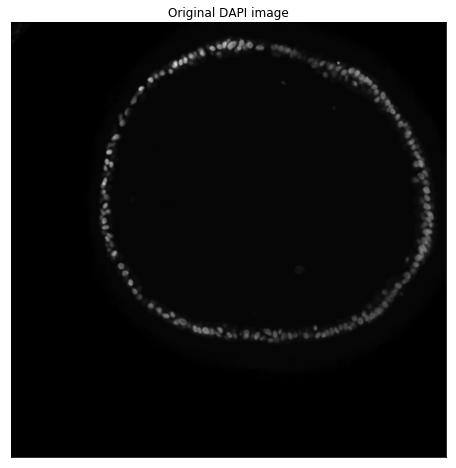

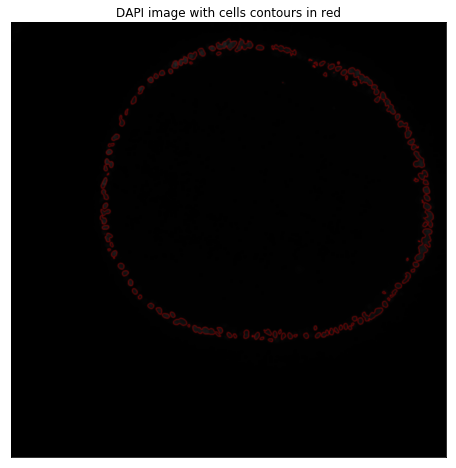

In [6]:
path = 'images/Images/r01c01f03p55-ch1sk1fk1fl1.tiff'

img = cv.imread(path,cv.IMREAD_GRAYSCALE)

copy = img.copy()

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
plt.title('Original DAPI image')
plt.imshow(copy, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

#The choice of the lower for this threshold could be specific to the chosen image.
ret,img = cv.threshold(img,8,255,0)

img, contours, hierarchy = cv.findContours(img,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

contours = [contour for i, contour in enumerate(contours) if hierarchy[0][i][3]==-1]

copy = cv.cvtColor(copy, cv.COLOR_GRAY2BGR)

cv.drawContours(copy, contours,-1, [255,0,0],1)

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
plt.title('DAPI image with cells contours in red')
plt.imshow(copy, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

## Organoid's borders detection

Once again the image processing parameters choice is unclear. For this particular image, the best parameters are 28 for the threshold LB and 9 for the gaussian blur.

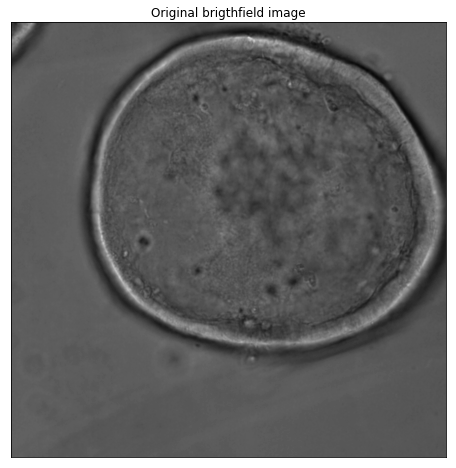

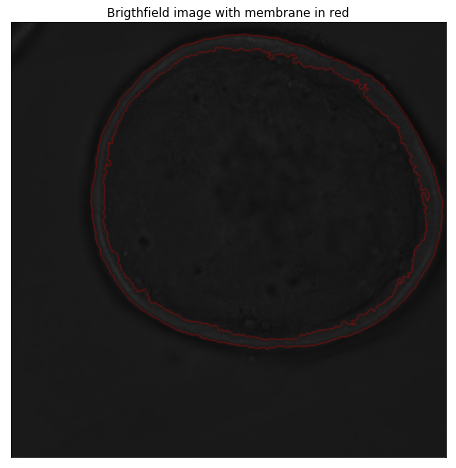

In [7]:
path = 'images/Images/r01c01f03p55-ch3sk1fk1fl1.tiff'


img = cv.imread(path,cv.IMREAD_GRAYSCALE)

copy = img.copy()

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
plt.title('Original brigthfield image')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

ret,img = cv.threshold(img,28,255,0)

img = cv.GaussianBlur(img,(9,9),0)


#img[img>28] = 255

img, contours, hierarchy = cv.findContours(img,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)

contours_length = [(len(contours[i]),i) for i in range(len(contours))]
contours_length.sort()
membrane_ind = contours_length[len(contours_length)-2:]


contours = [contours[ind[1]] for ind in membrane_ind]

copy = cv.cvtColor(copy, cv.COLOR_GRAY2BGR)

cv.drawContours(copy, contours,-1, [255,0,0],1)

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
plt.title('Brigthfield image with membrane in red')
plt.imshow(copy, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

## Using the data from the image to initialize the mesh

In [4]:
brigthfield_path = 'images/Images/r01c01f03p55-ch3sk1fk1fl1.tiff'
dapi_path = 'images/Images/r01c01f03p55-ch1sk1fk1fl1.tiff'
imgData = iP.dataImage(brigthfield_path, dapi_path)

#These two lines call the procedures demonstrated above to obtain the organoid parameters
brigthfield_data = imgData.brightfield_processing()
dapi_data = imgData.dapi_processing()

#defining de organoid using the data we saved above
Nf = len(imgData.clockwiseCenters)
R_in = imgData.rIn/imgData.shape[1]
R_out = imgData.rOut/imgData.shape[1]
inners = imgData.inside
outers = imgData.outside
centers = imgData.clockwiseCenters

#compute the vertices of the mesh
inner_vs, outer_vs = cpF.get_bissecting_vertices(centers, inners, outers)

#initialising the mesh
organo = tyssueMissing.generate_ring(Nf, R_in, R_out)

# adjustement
organo.vert_df.loc[organo.apical_verts, organo.coords] = inner_vs[::-1]
organo.vert_df.loc[organo.basal_verts, organo.coords] = outer_vs[::-1]

PlanarGeometry.update_all(organo)

# Construction of the model
model = factory.model_factory(
    [effectors.FaceAreaElasticity,
     effectors.LineTension],
    effectors.FaceAreaElasticity)

# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area': organo.face_df.area.mean(), #and there was an error here
        'area_elasticity': 1,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 1e-3,
        'is_active': 1
        },
    'vert':{
        'is_active': 1
        },
    }

organo.update_specs(specs, reset=True)

Reseting datasets values with new specs


# Initializing the gradient descent procedure

Nothing new here, we repeat the steps explained in the Gradient descent notebook



In [5]:
Y = np.column_stack([organo.vert_df.x, organo.vert_df.y])

minimize_opt = {'options':{'gtol':0.001,
                           'ftol':0.01}}

def distance(P):   
    L, A = P[:4*Nf], P[4*Nf:]
    tmpOrgano = organo.copy()
    tmpOrgano.edge_df.line_tension = L
    tmpOrgano.face_df.prefered_area = A
    #start = time.clock()
    solver.find_energy_min(tmpOrgano,
                             PlanarGeometry,
                            model,
                            minimize = minimize_opt)
    X = np.column_stack([tmpOrgano.vert_df.x, tmpOrgano.vert_df.y])
    #elapsed = time.clock()-start
    #print('distance computation :',elapsed)
    D = np.sum(np.linalg.norm((X-Y), axis = 1))
    return D

#scipy approx_fprime is slower because it compute the partial derivatice twice for lateral edges 
def grad(P,D):
    h = np.array([10**(-6)]*len(P))
    hP = np.tile(P,(len(P),1)) + np.eye(len(P))*10**(-6)
    start = time.clock()
    Ldf = np.array([distance(i) for i in hP[:3*Nf]]) - np.full(3*Nf,D)
    Ldf = np.concatenate([Ldf,np.roll(Ldf[2*Nf:len(Ldf)],-1)])
    Adf = np.array([distance(i) for i in hP[4*Nf:]]) - np.full(Nf,D)
    df = np.concatenate((Ldf, Adf))
    elapsed = time.clock()-start
    #print('gradient computation : ', round(elapsed,4))
    res = np.divide(df,h)
    return res

start = time.clock()
nonLateral = np.random.rand(int(len(organo.edge_df.line_tension)/2))*0.001
lateral = np.random.rand(int(len(organo.edge_df.line_tension)/4))*0.001
lateral = np.concatenate([lateral,np.roll(lateral,-1)])
L = np.concatenate([nonLateral, lateral])
#L contains line tensions. We need to ad equilibrium areas.
A = np.full(Nf, organo.face_df.area.mean())+np.random.rand(Nf)*0.01
P = np.concatenate((L,A))
D = distance(P)

previousStepSize = 10**6
cpt = 0
incumbent = 10**6

# Running the gradient descent procedure


In [6]:
print(f'starting with {Nf} noyaux')
while previousStepSize > 10**(-5) and incumbent > 0:
    cpt += 1
    #L = np.maximum(L - 0.01/cpt * opt.approx_fprime(L, distance,10**(-6)),np.zeros(len(L)))    
    P = np.maximum(P - 0.01 / cpt * grad(P,D),np.zeros(len(P)))    
    D = distance(P)
    previousStepSize = abs(D - incumbent)
    #print(f'Itération : {cpt-1} \n Distance : {round(D,5)}')
    #print('________________________________________')
    incumbent = D
optP = P
elapsed = time.clock()-start

organo.edge_df.line_tension = optP[:4*Nf]
organo.face_df.prefered_area = optP[4*Nf:]
solver.find_energy_min(organo,
                            PlanarGeometry,
                            model,
                            minimize = minimize_opt)

print('Solving time =',elapsed)

starting with 109 noyaux
Solving time = 406.5305479325031


## Plot

Mean line tension in basal edges : 0.0015195157797979013
Mean line tension in apical edges : 0.0017019938944480722
Mean line tension in lateral edges : 6.339454581146601e-05


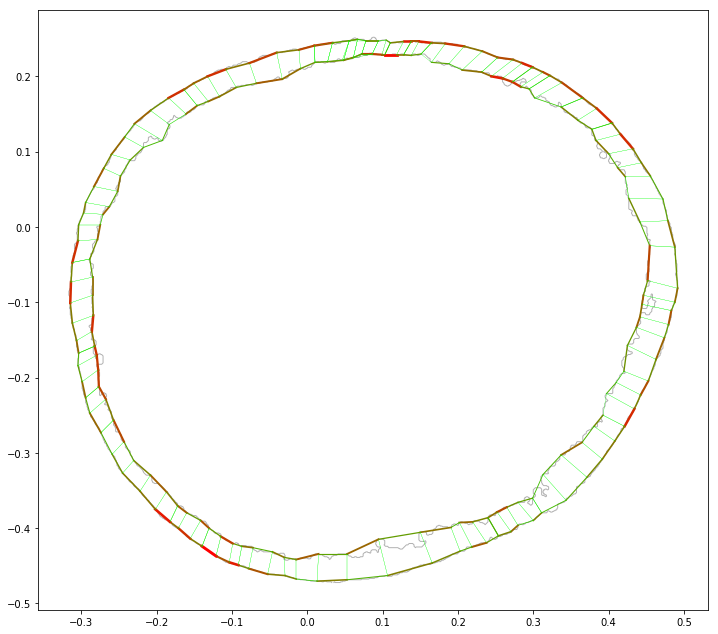

In [9]:
# Plot of the mesh
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax.plot(*inners.T, lw=1, alpha=0.6, c='gray')
ax.plot(*outers.T, lw=1, alpha=0.6, c='gray')
fig, ax = tyssueMissing.quick_edge_drawMod(organo, ax=ax)

ax.set(aspect='equal');

print(f'Mean line tension in basal edges : {np.mean(organo.edge_df.line_tension[organo.edge_df.segment == "basal"])}')
print(f'Mean line tension in apical edges : {np.mean(organo.edge_df.line_tension[organo.edge_df.segment == "apical"])}')
print(f'Mean line tension in lateral edges : {np.mean(organo.edge_df.line_tension[organo.edge_df.segment == "lateral"])}')

In [1]:
Nf

NameError: name 'Nf' is not defined